### RNN Color-Motion

Hopefully it works

In [4]:
# --- Imports ---
import os
import sys
import random
import pickle
import gymnasium as gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- GPU Configuration ---
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# --- Add Modules directory to Python path ---
module_path = os.path.abspath(os.path.join('.', 'Modules'))

if module_path not in sys.path:
    sys.path.append(module_path)
    print(f"Added '{module_path}' to sys.path")
else:
    print(f"'{module_path}' already in sys.path")

# --- Import custom modules ---
from env_mante import ColorMotionEnv
from actor_critic_song import ActorCriticAgent
from reinforce_song import train_agent
from helper_functions import plot_metrics, plot_firing_rates, plot_psychometric_curves_mante, load_model, save_model

# --- Set Random Seeds ---
seed_value = 1
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

print("Setup Complete.")

'/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/Segundo cuatrimestre/TFM/Código/Modules' already in sys.path
Setup Complete.


In [6]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "reward_correct": 1.0,
        "reward_aborted": -1.0,
        "reward_incorrect": 0.0,
        "reward_fixation": 0.01,
        "reward_go_fixation": -0.01,
        "input_noise_sigma": 0.01,
        "duration_params": [10, 10, 10, 10, 10],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-3,
        "l2_critic": 1e-3,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }

    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Mante environment...")
    env = ColorMotionEnv(
        dt=config["dt"],
        R_CORRECT=config["reward_correct"],
        R_ABORTED=config["reward_aborted"],
        R_FAIL=config["reward_incorrect"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        input_noise_sigma=config["input_noise_sigma"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, \
    actor_firing_rates, critic_firing_rates, measurements_coherences = train_agent(
        env=env,
        agent=agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"],
        print_interval=config["print_interval"],
        l2_actor=config["l2_actor"],
        l2_critic=config["l2_critic"],
        record_history=config["record_history"]
    )
    print("\nTraining finished.")

    # --- Save checkpoint ---
    this_stage = 1
    this_ckpt_dir = 'checkpoints/rnn_mante'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / "rnn_mante.pkl"
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_coherences
        ), f)

    # --- Plot Training Metrics & Psychometric Curve ---
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config["num_episodes"] // 50),
        window_2=max(50, config["num_episodes"] // 10)
    )

    plot_psychometric_curves_mante(
        measurements_coherences
    )


    # --- Close Environment ---
    print("Closing the environment...")
    env.close()
    print("Environment closed.")

if __name__ == '__main__':
    main()

Configuration loaded:
  dt: 10
  reward_correct: 1.0
  reward_aborted: -1.0
  reward_incorrect: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  input_noise_sigma: 0.01
  duration_params: [10, 10, 10, 10, 10]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.001
  critic_lr: 0.001
  num_episodes: 20000
  gamma: 1.0
  l2_actor: 0.001
  l2_critic: 0.001
  print_interval: 100
  record_history: 1
Creating Mante environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...
Agent Initialized.
Starting training for 20000 episodes...
Episode 100	Total Reward: -1.00	State [0. 1. 0. 0.]	Actor Loss: -0.8932	Critic Loss: 0.6419
Episode 200	Total Reward: -0.98	State [0. 1. 0. 0.]	Actor Loss: 0.4572	Critic Loss: 0.3676
Episode 300	Total Reward: 1.03	State [0. 1. 0. 0.]	Actor Loss: 2.3919	Critic Loss: 5.3209
Episode 400	Total Reward: 

KeyboardInterrupt: 

Configuration loaded:
  dt: 10
  reward_correct: 1.0
  reward_aborted: -1.0
  reward_incorrect: 0.0
  reward_fixation: 0.01
  reward_go_fixation: -0.01
  input_noise_sigma: 0.001
  duration_params: [10, 10, 10, 10, 10]
  actor_hidden_size: 50
  critic_hidden_size: 50
  actor_layers: 1
  critic_layers: 1
  layer_type: GRU_modified
  actor_prob_connection: 0.1
  critic_prob_connection: 1.0
  actor_lr: 0.004
  critic_lr: 0.004
  num_episodes: 20000
  gamma: 1.0
  l2_actor: 0.0001
  l2_critic: 0.0001
  print_interval: 100
  record_history: 1
Creating Mante environment...
Observation size: 4, Action size: 3
Initializing Actor-Critic Agent...
Agent Initialized.
Actor and Critic networks built.
Performing dummy forward to build cells and weights for mask loading...


/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'actor_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/c/Users/imcir/Desktop/CIENCIA DATOS/cienciadatosenv/lib/python3.12/site-packages/keras/src/layers/layer.py:396: UserWarning: `build()` was called on layer 'critic_model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Loading masks from stage 1...
Masks loaded.
Initializing optimizers with dummy step...
Optimizers initialized.
Restoring from checkpoint: checkpoints/rnn_mante_1/ckpt-1
Checkpoint restored successfully.
Starting training for 20000 episodes...
Episode 100	Total Reward: 0.02	State [0. 1. 0. 0.]	Actor Loss: 0.0001	Critic Loss: 0.2025
Episode 200	Total Reward: 1.02	State [0. 1. 0. 0.]	Actor Loss: 0.0011	Critic Loss: 0.2642
Episode 300	Total Reward: 1.02	State [0. 1. 0. 0.]	Actor Loss: 0.0010	Critic Loss: 0.2588
Episode 400	Total Reward: 1.02	State [1. 0. 0. 0.]	Actor Loss: 0.0008	Critic Loss: 0.2317
Episode 500	Total Reward: 1.02	State [0. 1. 0. 0.]	Actor Loss: 0.0008	Critic Loss: 0.2409
Episode 600	Total Reward: 1.02	State [1. 0. 0. 0.]	Actor Loss: 0.0007	Critic Loss: 0.2544
Episode 700	Total Reward: 0.02	State [1. 0. 0. 0.]	Actor Loss: 0.0003	Critic Loss: 0.2658
Episode 800	Total Reward: 0.02	State [0. 1. 0. 0.]	Actor Loss: 0.0002	Critic Loss: 0.2540
Episode 900	Total Reward: 1.02	State 

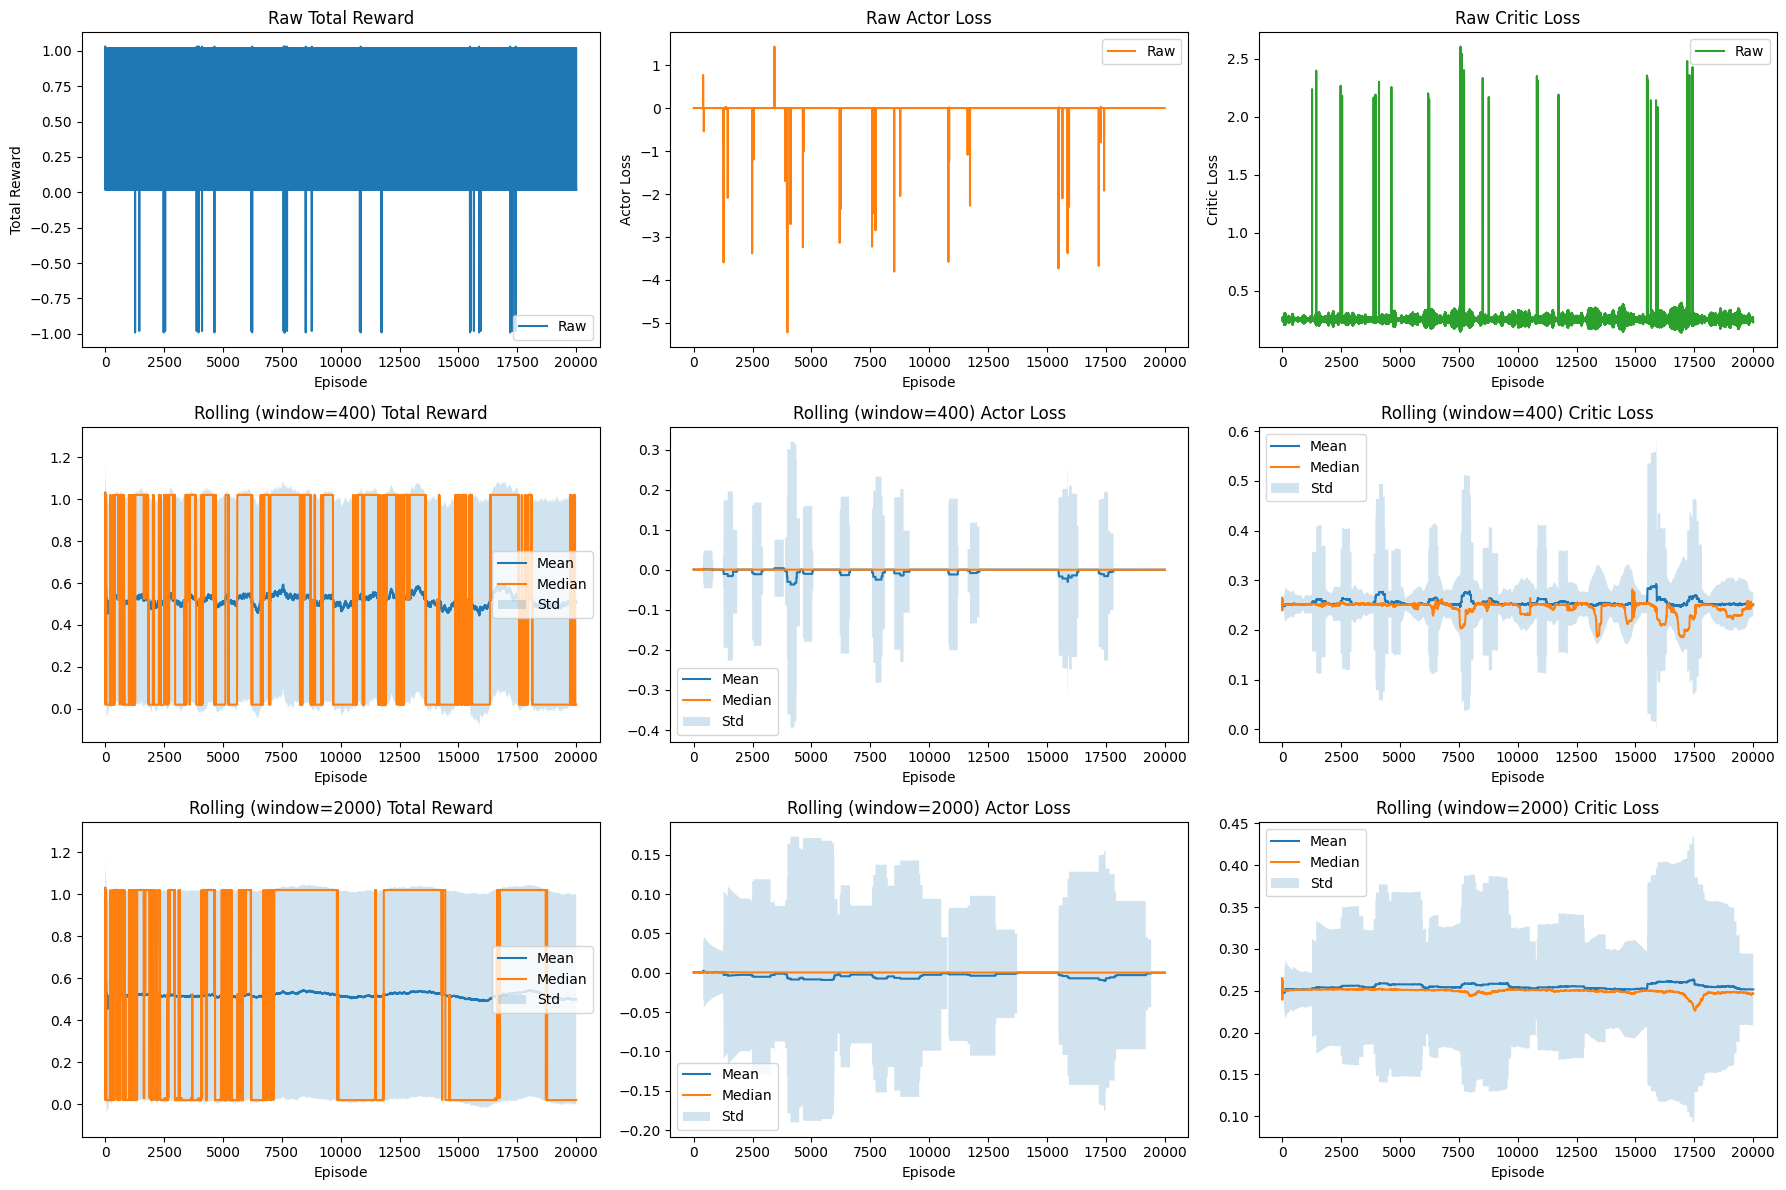

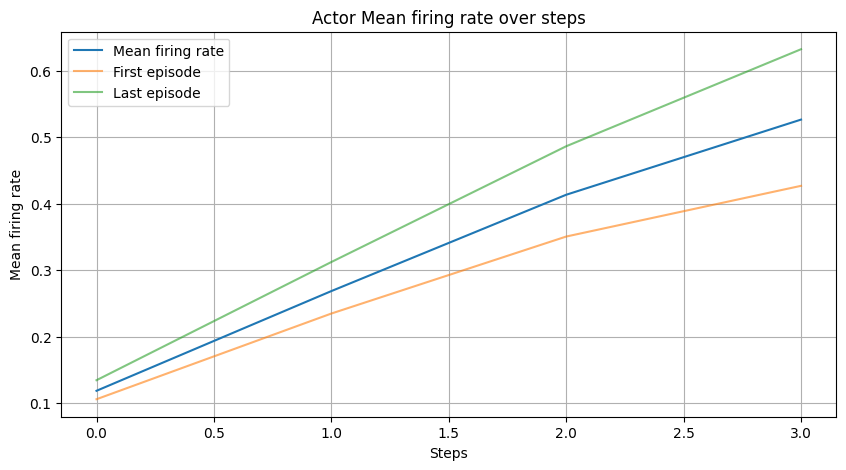

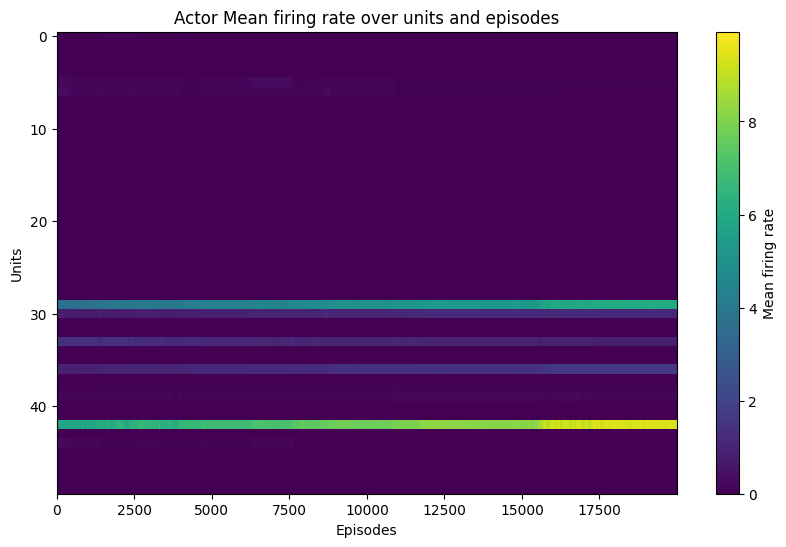

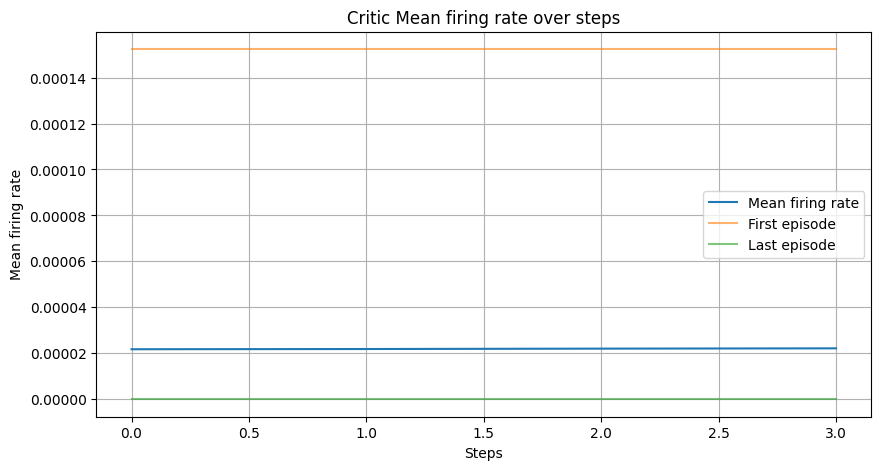

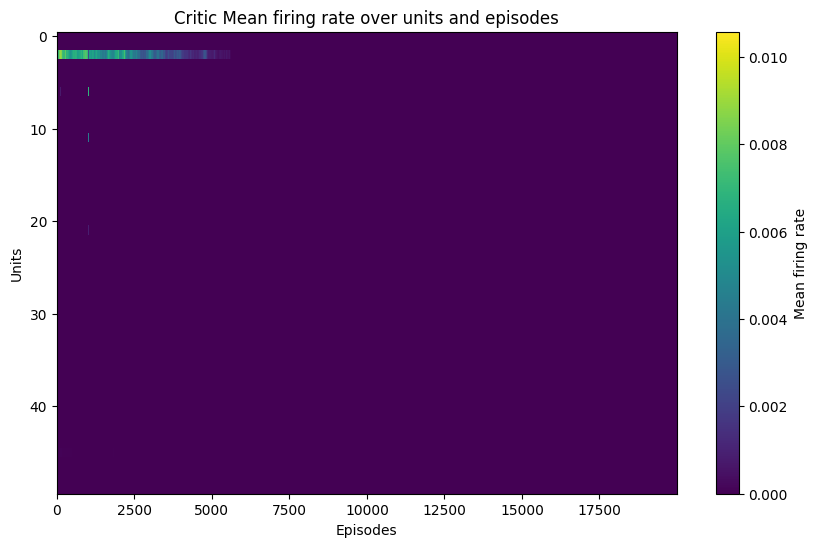

Plotting psychometric curve...


TypeError: 'NoneType' object is not subscriptable

In [3]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "reward_correct": 1.0,
        "reward_aborted": -1.0,
        "reward_incorrect": 0.0,
        "reward_fixation": 0.01,
        "reward_go_fixation": -0.01,
        "input_noise_sigma": 0.001,
        "duration_params": [10, 10, 10, 10, 10],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 4e-3,
        "critic_lr": 4e-3,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }
    
    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Mante environment...")
    env = ColorMotionEnv(
        dt=config["dt"],
        R_CORRECT=config["reward_correct"],
        R_ABORTED=config["reward_aborted"],
        R_FAIL=config["reward_incorrect"],
        reward_fixation=config["reward_fixation"],
        reward_go_fixation=config["reward_go_fixation"],
        input_noise_sigma=config["input_noise_sigma"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 2
    this_ckpt_dir = 'checkpoints/rnn_mante'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_coherences = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 2 finished.")

    # --- Save checkpoint ---
    this_stage = 2
    this_ckpt_dir = 'checkpoints/rnn_mante'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_mante_2.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_coherences
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )

    plot_firing_rates(actor_firing_rates, critic_firing_rates)

    print("Plotting psychometric curve...")
    
    plot_psychometric_curves_mante(measurements_coherences)

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()

In [ ]:
def main():
    # --- Training Configuration ---
    config = {
        # Environment params
        "dt": 10,
        "reward_correct": 1.0,
        "reward_aborted": -1.0,
        "reward_incorrect": 0.0,
        "reward_fixation": 0.01,
        "reward_decide_fixation": -0.01,    
        "input_noise_sigma": 0.001,
        "duration_params": [10, 10, 10, 10, 10, 10],
        # Agent architecture
        "actor_hidden_size": 50,
        "critic_hidden_size": 50,
        "actor_layers": 1,
        "critic_layers": 1,
        "layer_type": "GRU_modified",
        "actor_prob_connection": 0.1,
        "critic_prob_connection": 1.0,
        # Training hyperparams
        "actor_lr": 1e-3,
        "critic_lr": 1e-3,
        "num_episodes": 20000,
        "gamma": 1.0,
        "l2_actor": 1e-4,
        "l2_critic": 1e-4,
        # Training process
        "print_interval": 100,
        "record_history": 1
    }
    
    print("Configuration loaded:")
    for key, value in config.items():
        print(f"  {key}: {value}")

    # --- Environment Setup ---
    print("Creating Romo environment...")
    env = HigherFrequencyEnv(
        dt=config["dt"],
        reward_correct=config["reward_correct"],
        reward_aborted=config["reward_aborted"],
        reward_incorrect=config["reward_incorrect"],
        reward_fixation=config["reward_fixation"],
        reward_decide_fixation=config["reward_decide_fixation"],
        input_noise_sigma=config["input_noise_sigma"],
        duration_params=config["duration_params"]
    )
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n
    print(f"Observation size: {obs_size}, Action size: {act_size}")

    # --- Agent Setup ---
    print("Initializing Actor-Critic Agent...")
    agent = ActorCriticAgent(
        obs_size=obs_size,
        act_size=act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        actor_prob_connection=config["actor_prob_connection"],
        critic_prob_connection=config["critic_prob_connection"],
        layer_type=config["layer_type"]
    )
    print("Agent Initialized.")

    # --- Load checkpoint ---
    this_stage = 3
    this_ckpt_dir = 'checkpoints/rnn_romo'
    load_model(agent, obs_size, act_size, this_stage, this_ckpt_dir)

    # --- Training ---
    print(f"Starting training for {config['num_episodes']} episodes...")
    total_rewards_history, actor_loss_history, critic_loss_history, actor_firing_rates, critic_firing_rates, measurements_frequencies = train_agent(
        env=env,
        agent=agent,
        num_episodes=config['num_episodes'],
        gamma=config['gamma'],
        print_interval=config['print_interval'],
        l2_actor=config['l2_actor'],
        l2_critic=config['l2_critic'],
        record_history=config['record_history']
    )
    print("Training stage 3 finished.")

    # --- Save checkpoint ---
    this_stage = 3
    this_ckpt_dir = 'checkpoints/rnn_romo'
    save_model(agent, this_stage, this_ckpt_dir)

    # --- Save outputs ---
    output_dir  = Path.cwd() / "outputs"
    output_dir.mkdir(parents=True, exist_ok=True)
    output_file = output_dir / 'rnn_romo_3.pkl'
    with open(output_file, "wb") as f:
        pickle.dump((
            total_rewards_history,
            actor_loss_history,
            critic_loss_history,
            actor_firing_rates,
            critic_firing_rates,
            measurements_frequencies
        ), f)

    # --- Plot Metrics & Psych Curve ---
    print("Plotting training metrics...")
    plot_metrics(
        total_rewards_history,
        actor_loss_history,
        critic_loss_history,
        window_1=max(20, config['num_episodes']//50),
        window_2=max(50, config['num_episodes']//10)
    )
    print("Plotting psychometric curve...")
    
    # plot_psychometric_curve(measurements_juices, title="Psychometric Curve Stage 2")

    plot_firing_rates(actor_firing_rates, critic_firing_rates)

    # --- Cleanup ---
    print("Closing environment...")
    env.close()
    print("Done.")


if __name__ == '__main__':
    main()